### Random Forest: Diabetes Dataset

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Dataset

In [222]:
import pandas as pd
df_data = pd.read_csv('../datasets/diabetes.csv')

In [223]:
df_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Before performing data cleaning, we first closely examine five features: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI`, to check how many values are zero in each.

#### Identify and replacing missing data

In [224]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for feature in zero_features:
    zero_count = df_data[feature][df_data[feature] == 0].count()
    total_count = df_data[feature].count()
    percentage = round((100 * zero_count / total_count), 2)
    print(f'{feature} has {zero_count} zero entries ({percentage}%)')


Glucose has 5 zero entries (0.65%)
BloodPressure has 35 zero entries (4.56%)
SkinThickness has 227 zero entries (29.56%)
Insulin has 374 zero entries (48.7%)
BMI has 11 zero entries (1.43%)


Based on the results above, we can observe that a relatively large proportion of the values in the features SkinThickness and Insulin are zero.\
In such cases, it's usually necessary to consult medical professionals or experts in the relevant field to determine whether these zero values are reasonable.\
In addition, we can use statistical methods to handle these zeros, such as filling in the mean or median, to improve the completeness and accuracy of the data.\
In this example, we attempt to replace all zero values with the median, so we can use the built-in median() function in pandas to quickly calculate the median value for each feature in the dataset.

In [225]:
df_data[zero_features].median()

Glucose          117.0
BloodPressure     72.0
SkinThickness     23.0
Insulin           30.5
BMI               32.0
dtype: float64

In [226]:
df_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [227]:
# Get the mean of each feature
zero_features_mean = df_data[zero_features].mean()

# Replace zero value with mean
df_data[zero_features] = df_data[zero_features].replace(0, zero_features_mean)

#### Visualize features distribution with histogram

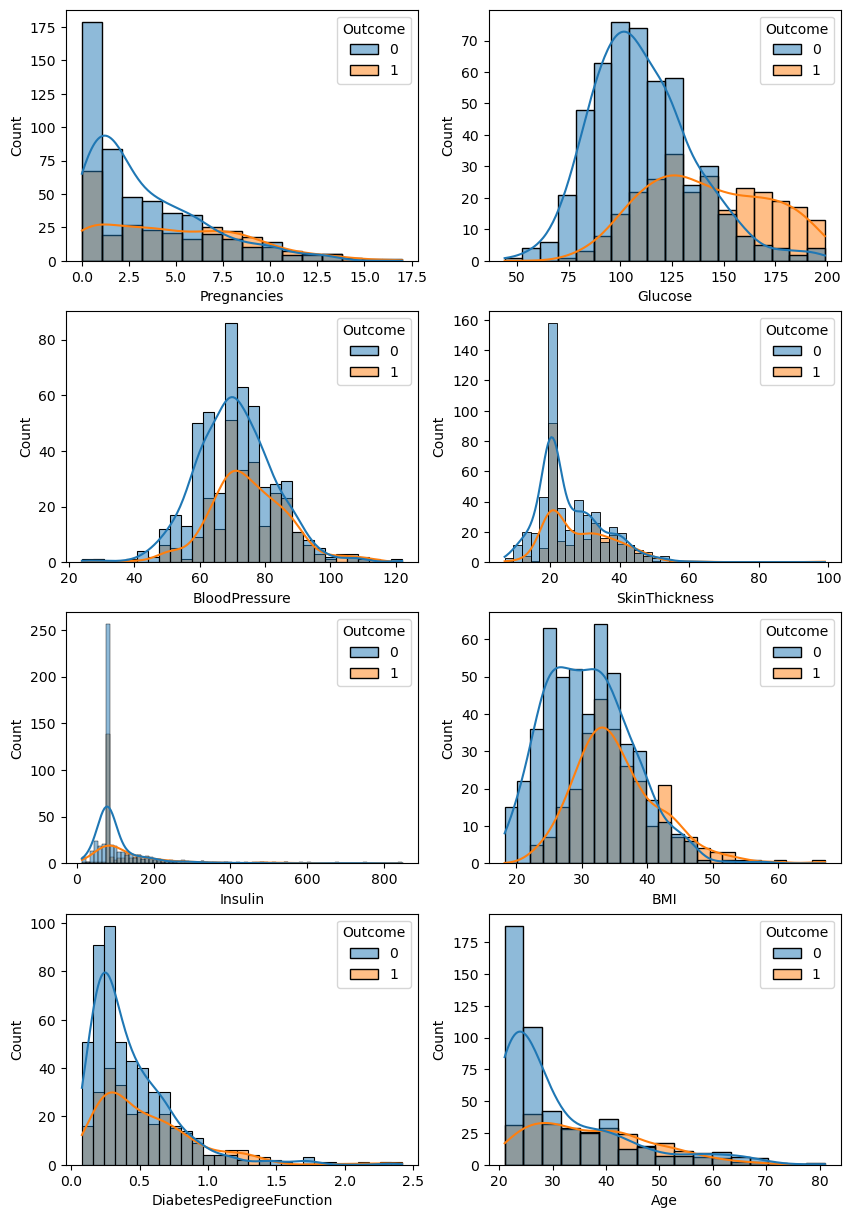

In [228]:
x_feature_names = ['Pregnancies', 'Glucose', 'BloodPressure',
                   'SkinThickness', 'Insulin', 'BMI',
                   'DiabetesPedigreeFunction', 'Age']

fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for ax, name in zip(axes.flatten(), x_feature_names):
    sns.histplot(data=df_data, x=name, hue='Outcome',
                 palette='tab10', ax=ax, kde=True)

From the chart above, we can observe that `Glucose` (blood glucose concentration), `BMI` (body mass index), and `Age` are three features whose data distributions differ significantly depending on whether the individual has diabetes or not.

#### Class Distribution Analysis

We can observe the number of different output categories and evaluate the balance of the labels in the dataset.\
In the coding section, we use the countplot() function from the Seaborn library to create bar charts, with the height of each bar representing the sample count for each category.\
To further enhance the readability of the chart, we use the bar_label() function to display the count value above each bar.

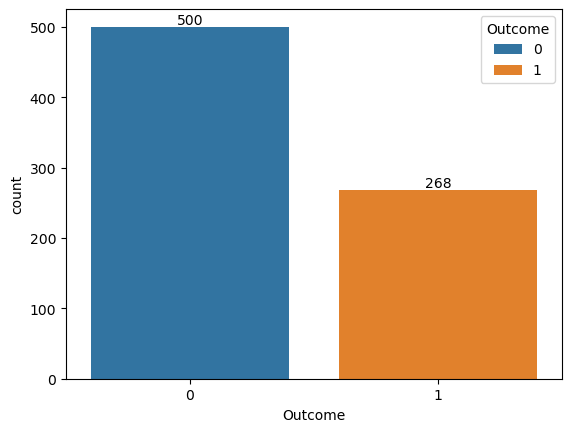

In [229]:
# Use seaborn's countplot() to create a bar chart
ax = sns.countplot(data=df_data, x='Outcome', hue='Outcome', palette='tab10')

# Add value labels to the bars
for container in ax.containers:
    ax.bar_label(container)

-   **Outcome = 0** (non-diabetic): 500 samples

-   **Outcome = 1** (diabetic): 268 samples

🔍 **Insight**: The dataset is **imbalanced**, which may affect model training and evaluation.

#### Splitting Data into Training and Testing Sets

After data cleaning, we must divide the dataset into a training set and a test set.\
This allows us to ensure that the data used during training and the data used for testing are relatively independent, so we can more accurately evaluate the model's performance.\

We use the train_test_split() function to accomplish this step. It takes the input features and labels and splits them into training and testing sets based on a specified ratio.\
In this example, we set the test_size parameter, which indicates the proportion allocated to the test set. For instance, setting it to 0.1 means 10% of the data is used for testing.

In [230]:
from sklearn.model_selection import train_test_split

# Separate the features (X) by dropping the 'Outcome' column
X = df_data.drop(['Outcome'], axis=1).values

# Extract the target variable (y), which is the 'Outcome' column
y = df_data['Outcome'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42, stratify=y)

print('Shape of training set X: ', X_train.shape)
print('Shape of training set y: ', X_test.shape)


Shape of training set X:  (691, 8)
Shape of training set y:  (77, 8)


#### Build Random Forest Model

In [231]:
from sklearn.ensemble import RandomForestClassifier

# Random forest model
random_forest_clf = RandomForestClassifier(n_estimators=33, random_state=42)

# Train the model
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=33, random_state=42)

#### Model Evaluation

In [232]:
train_accuracy = random_forest_clf.score(X_train, y_train)
test_accuracy = random_forest_clf.score(X_test, y_test)

print('Train set accuracy: ', train_accuracy)
print('Test set accuracy: ', test_accuracy)

Train set accuracy:  0.9985528219971056
Test set accuracy:  0.7922077922077922


In [233]:
# classification report
from sklearn.metrics import classification_report

# model prediction
y_pred = random_forest_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84        50
           1       0.69      0.74      0.71        27

    accuracy                           0.79        77
   macro avg       0.77      0.78      0.78        77
weighted avg       0.80      0.79      0.79        77



The model performs well overall, especially in `predicting non-diabetic patients` (high recall and F1).\
However, its performance on predicting `diabetic patients` is weaker, with a lower recall (0.56), meaning it misses some actual diabetic cases.

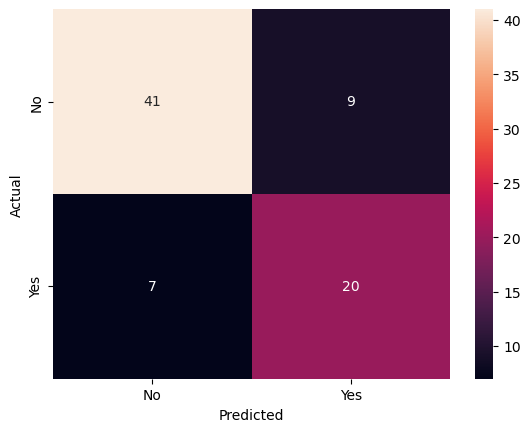

In [234]:
# Evaluation with Confusion Matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(actual_val, pred_val, labels, title=None):
    confusion_matrix = pd.crosstab(actual_val, pred_val, rownames=['Actual'], colnames=['Predicted'])
    plot = sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt=',.0f')

    if title is None:
        pass
    else:
        plot.set_title(title)
    
    plt.show()

plot_confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])

In the medical context, especially for diabetes detection problems, `recall` is usually considered the top-priority evaluation metric. Recall measures the proportion of actual diabetes patients that the model correctly identifies.\
In this scenario, if a person with diabetes is mistakenly classified as non-diabetic (a false negative), it may cause them to miss timely treatment opportunities, potentially leading to adverse health effects.\
Therefore, in this application, `recall` better reflects the model’s effectiveness in detecting the disease, and is typically regarded as a more important evaluation metric.

#### Understand / Identify the important feature

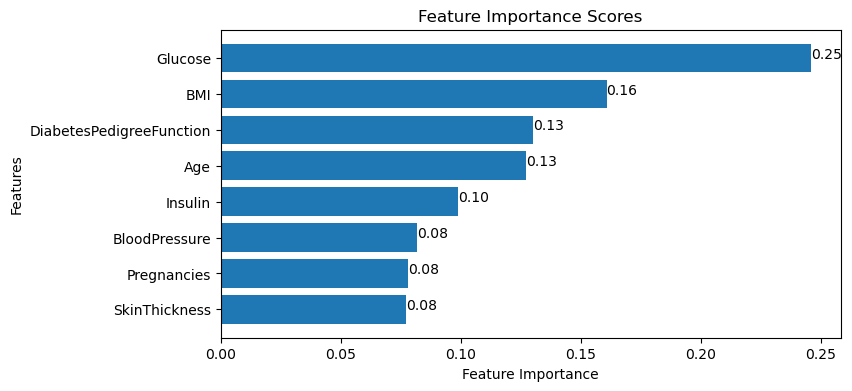

In [235]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve feature importances
importances = random_forest_clf.feature_importances_

# Get sorted indices
indices = np.argsort(importances)

# Plotting
plt.figure(figsize=(8, 4))
bar_plot = plt.barh(range(len(x_feature_names)), importances[indices], align='center')
plt.yticks(range(len(x_feature_names)), [x_feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Scores')

# Add value labels
for rect in bar_plot:
    width = rect.get_width()
    plt.annotate(f'{width:.2f}', xy=(width, rect.get_y() + rect.get_height() / 2))
plt.show()


Understanding the relative importance of features helps interpret the model’s decision-making process.\
In the medical field, such results can assist doctors or healthcare professionals in better understanding how the model makes predictions, and can offer valuable clinical insights.\
It is recommended to try experimenting on as increasing or reducing the complexity of the decision trees—to observe how it affects prediction accuracy.

#### 